## Project: Titanic Survival Exploration

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive.

# Getting Started
To begin working with the RMS Titanic passenger data, we'll first need to `import` the functionality we need, and load our data into a `PySpark` DataFrame.  
Run the code cell below to load our data and display the first few entries (passengers) for examination using the `.show()` function.

In [1]:
# Import libraries necessary for this project
from random import seed, choice
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Initialize Spark and SQL Contexts
spark_context = SparkContext()
sc = SQLContext(spark_context)

# Load the dataset
data = sc.read.csv('titanic_data.csv', header=True, inferSchema=True)
data.cache()

# Print the first few entries of the RMS Titanic data
data.show(20)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

To measure the performance of our predictions, we need a metric to score our predictions against the true outcomes of survival. Since we are interested in how *accurate* our predictions are, we will calculate the proportion of passengers where our prediction of their survival is correct. Run the code cell below to create our `accuracy_score` function and test a prediction on the first five passengers.  

**Think:** *Out of the first five passengers, if we predict that all of them survived, what would you expect the accuracy of our predictions to be?*

In [2]:
def accuracy_score(truth_and_preds):
    """ Returns accuracy score for input truth and predictions. """
    acc = (truth_and_preds.filter('class == predictions').count() / truth_and_preds.count()) * 100
    return "Predictions have an accuracy of {:.2f}%.".format(acc)

# Test the 'accuracy_score' function
seed('7777')
schema = StructType([StructField('class', IntegerType(), True), StructField('predictions', IntegerType(), True)])
predictions_df = sc.createDataFrame(spark_context.emptyRDD(), schema=schema)
for i in range(20):
    predictions_df = predictions_df.union(sc.createDataFrame([[choice([0,1]), choice([0, 1])]]))
predictions_df.show()
print(accuracy_score(predictions_df))

+-----+-----------+
|class|predictions|
+-----+-----------+
|    1|          0|
|    0|          0|
|    0|          0|
|    0|          1|
|    0|          1|
|    0|          1|
|    1|          1|
|    1|          1|
|    1|          1|
|    1|          1|
|    1|          0|
|    0|          1|
|    0|          1|
|    1|          0|
|    0|          0|
|    1|          0|
|    1|          1|
|    0|          0|
|    1|          1|
|    1|          0|
+-----+-----------+

Predictions have an accuracy of 50.00%.


# Making Predictions

If we were asked to make a prediction about any passenger aboard the RMS Titanic whom we knew nothing about, then the best prediction we could make would be that they did not survive. This is because we can assume that a majority of the passengers (more than 50%) did not survive the ship sinking.  
The `predictions_0` function below will always predict that a passenger did not survive.

In [3]:
def predictions_0(data_in):
    """ Model with no features. Always predicts a passenger did not survive. """
    return data_in.withColumn('predictions', lit(0))

# Make the predicitons
data_predictions = predictions_0(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 1
*Using the RMS Titanic data, how accurate would a prediction be that none of the passengers survived?*  
Run the code cell below to see the accuracy of this prediction.

In [4]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 61.62%.


**Answer:** *61.62%*

***
Let's take a look at whether the feature **Sex** has any indication of survival rates among passengers using the `survival_stats` function. This function is defined in the `visuals.py` Python script included with this project. The first two parameters passed to the function are the RMS Titanic data and passenger survival outcomes, respectively. The third parameter indicates which feature we want to plot survival statistics across.  
Run the code cell below to plot the survival outcomes of passengers based on their sex.

**NOTE:** The `PySpark` DataFrame has to be converted to a `Pandas` DataFrame inorder to be able to perform data visualizations.

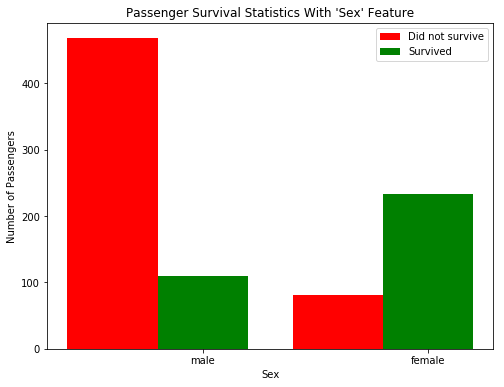

In [5]:
vs.survival_stats(data.drop('Survived').toPandas(), data.select('Survived').toPandas()['Survived'], 'Sex')

Examining the survival statistics, a large majority of males did not survive the ship sinking. However, a majority of females *did* survive the ship sinking. Let's build on our previous prediction: If a passenger was female, then we will predict that they survived. Otherwise, we will predict the passenger did not survive.  

In [6]:
def predictions_1(data_in):
    """ Model with no features. Always predicts a passenger did not survive. """
    check_sex_udf = udf(lambda sex: 1 if sex == 'female' else 0, IntegerType())
    return data_in.withColumn('predictions', check_sex_udf(data_in['Sex']))

# Make the predicitons
data_predictions = predictions_1(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 2
*How accurate would a prediction be that all female passengers survived and the remaining passengers did not survive?*  
Run the code cell below to see the accuracy of this prediction.

In [7]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 78.68%.


**Answer**: *78.68%*

***
Using just the **Sex** feature for each passenger, we are able to increase the accuracy of our predictions by a significant margin. Now, let's consider using an additional feature to see if we can further improve our predictions. For example, consider all of the male passengers aboard the RMS Titanic: Can we find a subset of those passengers that had a higher rate of survival? Let's start by looking at the **Age** of each male, by again using the `survival_stats` function. This time, we'll use a fourth parameter to filter out the data so that only passengers with the **Sex** 'male' will be included.  
Run the code cell below to plot the survival outcomes of male passengers based on their age.

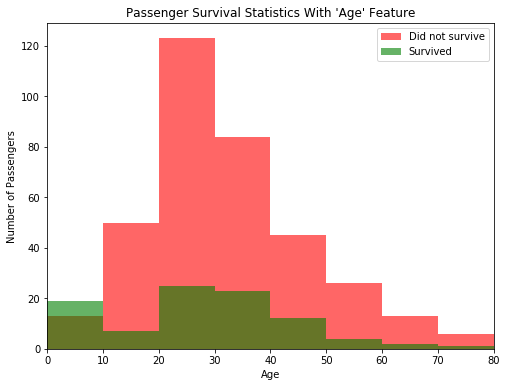

In [8]:
vs.survival_stats(data.drop('Survived').toPandas(), data.select('Survived').toPandas()['Survived'], 'Age', ["Sex == 'male'"])

Examining the survival statistics, the majority of males younger than 10 survived the ship sinking, whereas most males age 10 or older *did not survive* the ship sinking. Let's continue to build on our previous prediction: If a passenger was female, then we will predict they survive. If a passenger was male and younger than 10, then we will also predict they survive. Otherwise, we will predict they do not survive.

In [9]:
def predictions_2(data_input):
    """ Model with two features: 
            - Predict a passenger survived if they are female.
            - Predict a passenger survived if they are male and younger than 10. """
    # age_sex_udf = udf(lambda age, sex: type(row), StringType())
    age_sex_udf = udf(lambda age, sex: 1 if sex == 'female' else 1 if age != None and age < 10 else 0, IntegerType())
    return data_input.withColumn('predictions', age_sex_udf(col('Age'), col('Sex')))

# Make the predictions
data_predictions = predictions_2(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 3
*How accurate would a prediction be that all female passengers and all male passengers younger than 10 survived?*  
Run the code cell below to see the accuracy of this prediction.

In [10]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 79.35%.


**Answer**: *79.35%*

***
Adding the feature **Age** as a condition in conjunction with **Sex** improves the accuracy by a small margin more than with simply using the feature **Sex** alone. Now it's your turn: Find a series of features and conditions to split the data on to obtain an outcome prediction accuracy of at least 80%. This may require multiple features and multiple levels of conditional statements to succeed. You can use the same feature multiple times with different conditions.   
**Pclass**, **Sex**, **Age**, **SibSp**, and **Parch** are some suggested features to try.

Feel free to use the `survival_stats` function below to to examine various survival statistics.  
**Hint:** To use mulitple filter conditions, put each condition in the list passed as the last argument. Example: `["Sex == 'male'", "Age < 18"]`

In [11]:
temp_data = data.drop('Survived').toPandas()
temp_outcomes = data.select('Survived').toPandas()['Survived']

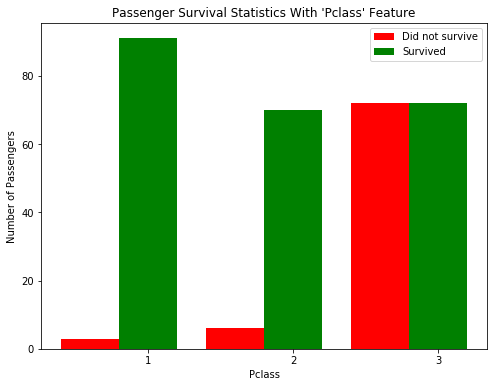

In [12]:
vs.survival_stats(temp_data, temp_outcomes, 'Pclass', ['Sex == "female"'])

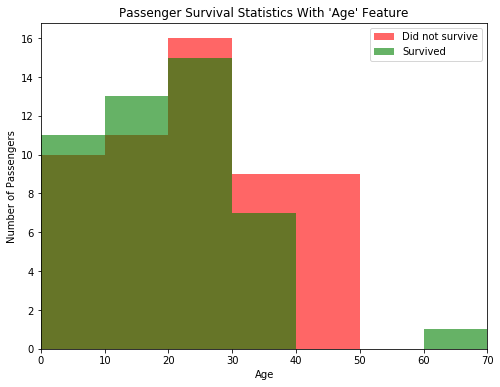

In [13]:
vs.survival_stats(temp_data, temp_outcomes, 'Age', ['Sex == "female"', 'Pclass == 3'])

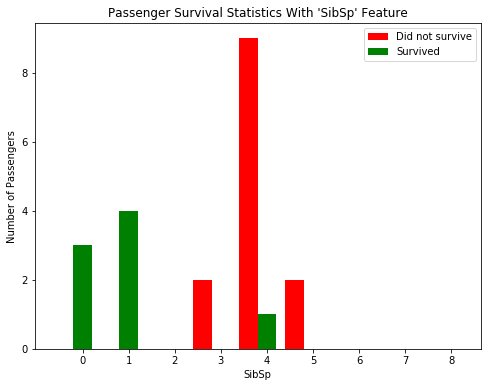

In [14]:
vs.survival_stats(temp_data, temp_outcomes, 'SibSp', ['Sex == "male"', 'Pclass == 3', 'Age < 10'])

In [15]:
def predictions_3(data_in):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    def check_conditions(vals):
        if vals[1] == 'female':
            if vals[2] == 3 and vals[0] != None and vals[0] < 50 and vals[0] > 20:
                return 0
            else:
                return 1
        elif vals[0] != None and vals[0] < 10 and vals[2] != 3 and vals[3] < 3:
            return 1
        else:
            return 0

    multi_feature_check_udf = udf(lambda *arr: check_conditions(arr) , IntegerType())
    return data_in.withColumn('predictions', multi_feature_check_udf(col('Age'), col('Sex'), col('Pclass'), col('SibSp')))

# Make the predictions
data_predictions = predictions_3(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 4
*Describe the steps you took to implement the final prediction model so that it got an accuracy of at least 80%. What features did you look at? Were certain features more informative than others? Which conditions did you use to split the survival outcomes in the data? How accurate are your predictions?*  
Run the code cell below to see the accuracy of your predictions.

In [16]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 81.03%.


**Answer**: 
*First, I started with the female passengers and looked for conditions where they did not survive. When I looked at the Pclass attribute of female passengers, I found that 50% of the female passengers with Pclass equal to 3 did not survive. So, I added this condition to the filter. Then, I looked at the Age attribute for female passengers with Pclass equal to 3 and I found that most of these passengers between the age 20 and 50 had not survived. These are the conditions I used for the female passengers.
Then, I planned on digging more into the data about male passengers. I found that 60% of the male passengers with the age less than 10 and Pclass equal to 3 did not survive. When I checked the SibSp attribute for the above filters, I found that for SibSp less than 3, all the passengers had survived. I executed all of the above conditions and got an accuracy above 80%.
My Predictions got an accuracy of 81.03%.*

In [17]:
# Stop the Spark session
spark_context.stop()

# Conclusion

After several iterations of exploring and conditioning on the data, we have built a useful algorithm for predicting the survival of each passenger aboard the RMS Titanic. The technique applied in this project is a manual implementation of a simple machine learning model, the *decision tree*. A decision tree splits a set of data into smaller and smaller groups (called *nodes*), by one feature at a time. Each time a subset of the data is split, our predictions become more accurate if each of the resulting subgroups are more homogeneous (contain similar labels) than before. The advantage of having a computer do things for us is that it will be more exhaustive and more precise than our manual exploration above. [This link](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) provides another introduction into machine learning using a decision tree.

A decision tree is just one of many models that come from *supervised learning*. In supervised learning, we attempt to use features of the data to predict or model things with objective outcome labels. That is to say, each of our data points has a known outcome value, such as a categorical, discrete label like `'Survived'`, or a numerical, continuous value like predicting the price of a house.

### Question 5
*Think of a real-world scenario where supervised learning could be applied. What would be the outcome variable that you are trying to predict? Name two features about the data used in this scenario that might be helpful for making the predictions.*  

**Answer**: *One of the real-world scenarios where supervised learning could be applied is in predicting whether a person is credit-worthy for a loan sanction or not. The outcome variable would take the answers 'yes' or 'no'. Two helpful features would be the person's credit score and current salary.*